<a href="https://colab.research.google.com/github/KurniaTanggang/model_datatimeseries/blob/main/datatimeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Daily Forex Data Since 2011-01-01  
Dataset : https://www.kaggle.com/altinsoyemrecan/daily-updated-forex-data-since-201111  

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data_train = pd.read_csv('forex_usd_data.csv')
data_train

,date(y-m-d),Argentine Peso,Australian Dollar,Bahraini Dinar,Botswana Pula,Brazilian Real,Bruneian Dollar,Bulgarian Lev,Canadian Dollar,Chilean Peso,Chinese Yuan Renminbi,Colombian Peso,Croatian Kuna,Czech Koruna,Danish Krone,Euro,Hong Kong Dollar,Hungarian Forint,Icelandic Krona,Indian Rupee,Indonesian Rupiah,Iranian Rial,Israeli Shekel,Japanese Yen,Kazakhstani Tenge,South Korean Won,Kuwaiti Dinar,Libyan Dinar,Malaysian Ringgit,Mauritian Rupee,Mexican Peso,Nepalese Rupee,New Zealand Dollar,Norwegian Krone,Omani Rial,Pakistani Rupee,Philippine Peso,Polish Zloty,Qatari Riyal,Romanian New Leu,Russian Ruble,Saudi Arabian Riyal,Singapore Dollar,South African Rand,Sri Lankan Rupee,Swedish Krona,Swiss Franc,Taiwan New Dollar,Thai Baht,Trinidadian Dollar,Turkish Lira,Emirati Dirham,British Pound,Venezuelan Bolivar
0,2011-01-01,3.969000,0.977326,0.377050,6.472492,1.659500,1.284500,1.463830,0.997700,467.750000,6.591000,1915.000000,5.518000,18.683500,5.567100,0.746798,7.773000,208.110000,115.050000,44.700001,9000.000000,10303.000000,3.548000,81.150000,147.300003,1120.599976,0.281250,1.253000,3.084500,29.799999,12.361000,71.099998,1.281394,5.819900,0.38504,85.610001,43.639999,2.961350,3.641000,3.194600,30.477500,3.750100,1.284500,6.630000,110.940002,6.721450,0.934500,29.140000,30.020000,6.340000,1.537400,3.67310,0.640553,4.300000e+00
1,2011-01-02,3.969000,0.977326,0.377050,6.472492,1.659500,1.283500,1.463830,0.997700,467.750000,6.591000,1915.000000,5.518000,18.683500,5.565000,0.746850,7.773000,208.110000,115.050000,44.700001,9000.000000,10303.000000,3.540000,81.190002,147.300003,1120.599976,0.281250,1.253000,3.084500,29.799999,12.361000,71.099998,1.281394,5.816900,0.38504,85.610001,43.639999,2.960800,3.641000,3.194600,30.477500,3.750100,1.283500,6.630000,110.940002,6.721450,0.933800,29.099001,30.020000,6.340000,1.537400,3.67310,0.641067,4.300000e+00
2,2011-01-03,3.973500,0.980569,0.377055,6.472492,1.646288,1.284367,1.462799,0.990444,465.649994,6.591000,1915.500000,5.523469,18.721212,5.574240,0.747910,7.768583,207.861502,115.470000,44.590000,8985.000000,10369.000006,3.541195,81.547858,147.325012,1124.705522,0.281000,1.251200,3.066000,30.799999,12.257083,71.599998,1.288409,5.827791,0.38506,85.750000,43.799999,2.954452,3.641250,3.195117,30.533764,3.750230,1.284367,6.614995,110.919998,6.693788,0.933069,29.120000,30.084999,6.390000,1.557411,3.67320,0.645615,4.300000e+00
3,2011-01-04,3.971000,0.995580,0.377060,6.480881,1.666747,1.287438,1.469525,0.999076,487.850006,6.608000,1902.699958,5.552787,18.714335,5.600075,0.751387,7.769715,207.641879,114.850000,45.062222,8982.000001,10355.000018,3.523856,81.956135,147.320007,1124.059737,0.281180,1.253400,3.063500,29.850002,12.255199,71.599999,1.303845,5.869423,0.38500,85.700000,43.550002,2.957570,3.641400,3.208305,30.368421,3.750250,1.287438,6.697076,110.820000,6.726967,0.947903,29.175004,30.104903,6.360000,1.547801,3.67315,0.641558,4.300000e+00
4,2011-01-05,3.971500,0.999522,0.377050,6.548788,1.670312,1.291450,1.485031,0.994376,495.149993,6.588500,1901.699951,5.618698,18.846590,5.657994,0.759228,7.770753,209.305328,115.910000,45.359878,8985.000000,10353.000006,3.547783,83.221293,147.075012,1127.004628,0.281900,1.262100,3.068500,30.499680,12.194041,72.599998,1.312401,5.903995,0.38506,85.809918,43.900002,2.940388,3.641492,3.237569,30.379534,3.750234,1.291450,6.719997,110.820000,6.766127,0.964490,29.170000,30.216193,6.380000,1.543853,3.67310,0.645308,4.300000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,2021-09-09,98.049172,1.355241,0.376000,11.176220,5.279172,1.342490,1.653989,1.265321,793.263279,6.454031,3832.038958,6.329695,21.504554,6.288487,0.845671,7.777781,296.676725,127.518343,73.561435,14261.192470,42025.575531,3.205913,109.772159,426.370910,1169.705513,0.300946,4.510973,4.148169,42.525723,19.934494,118.250007,1.40

In [ ]:
data_train.isnull().sum()

date(y-m-d)              0
Argentine Peso           0
Australian Dollar        0
Bahraini Dinar           0
Botswana Pula            0
Brazilian Real           0
Bruneian Dollar          0
Bulgarian Lev            0
Canadian Dollar          0
Chilean Peso             0
Chinese Yuan Renminbi    0
Colombian Peso           0
Croatian Kuna            0
Czech Koruna             0
Danish Krone             0
Euro                     0
Hong Kong Dollar         0
Hungarian Forint         0
Icelandic Krona          0
Indian Rupee             0
Indonesian Rupiah        0
Iranian Rial             0
Israeli Shekel           0
Japanese Yen             0
Kazakhstani Tenge        0
South Korean Won         0
Kuwaiti Dinar            0
Libyan Dinar             0
Malaysian Ringgit        0
Mauritian Rupee          0
Mexican Peso             0
Nepalese Rupee           0
New Zealand Dollar       0
Norwegian Krone          0
Omani Rial               0
Pakistani Rupee          0
Philippine Peso          0
P

In [ ]:
dates = data_train['date(y-m-d)'].values
temp  = data_train['Brazilian Real'].values

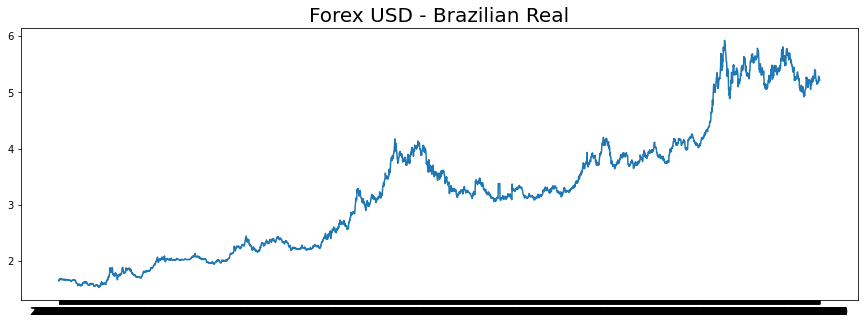

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Forex USD - Brazilian Real',
          fontsize=20);

In [ ]:
# Split dataset, validation 20%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, shuffle = False )

In [ ]:
# merubah data menjadi tipe numpy
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# membangun model
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=64, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
Mae = (data_train['Brazilian Real'].max() - data_train['Brazilian Real'].min()) * 0.1
print(Mae)

0.4389006


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< Mae):
      print("\nOK")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100
16/16 [==============================] - 11s 350ms/step - loss: 2.4483 - mae: 2.9483 - val_loss: 4.7192 - val_mae: 5.2192
Epoch 2/100
16/16 [==============================] - 5s 270ms/step - loss: 2.3829 - mae: 2.8829 - val_loss: 4.6259 - val_mae: 5.1259
Epoch 3/100
16/16 [==============================] - 5s 300ms/step - loss: 2.2686 - mae: 2.7686 - val_loss: 4.4554 - val_mae: 4.9554
Epoch 4/100
16/16 [==============================] - 5s 294ms/step - loss: 2.1372 - mae: 2.6372 - val_loss: 4.3052 - val_mae: 4.8052
Epoch 5/100
16/16 [==============================] - 5s 300ms/step - loss: 2.0366 - mae: 2.5366 - val_loss: 4.2112 - val_mae: 4.7112
Epoch 6/100
16/16 [==============================] - 5s 293ms/step - loss: 1.9617 - mae: 2.4617 - val_loss: 4.1270 - val_mae: 4.6270
Epoch 7/100
16/16 [==============================] - 5s 300ms/step - loss: 1.8930 - mae: 2.3930 - val_loss: 4.0458 - val_mae: 4.5458
Epoch 8/100
16/16 [==============================] - 5s 289ms/step -

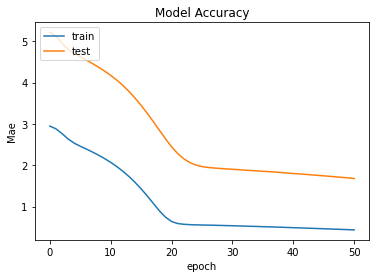

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

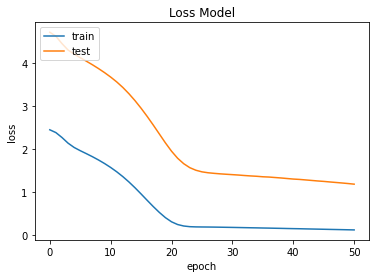

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()